In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import coo_matrix, hstack

In [2]:
#split url into tokens
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

In [3]:
#F05 - count the number of characters in host and in path
def split(input):
    characterInHost = []
    characterInPath = []
    
    for i in input:
        url_alap = i
        
        if re.match("http://", url_alap) or re.match("https://", url_alap):                  
            url = url_alap.split('//')                        
            protocol = url[0] + "//"
            host = url[1].split('/')[0]          #IndexError: list index out of range -> fixed
            url = protocol + host                #https-paypal.verifications-updates.com/
            path = ""
            if len(url_alap.split(url)) > 1:
                path = url_alap.split(url)[1]            
        else:
            if re.search("/", url_alap):
                url = url_alap.split('/')
                host = url[0]
                path = url_alap.split(host)[1]
                
            else:
                host = url_alap
                path = ""
                
        characterInHost.append(host.count('-') + host.count('_') + host.count('@'))
        characterInPath.append(path.count('-') + path.count('_') + path.count('@') + path.count('.'))
        
    return (characterInHost, characterInPath)

In [4]:
#F07 - count the size of the url
def urlSize(input):
    sizeOfUrl = []
    
    for i in input:
        sizeOfUrl.append(len(i));
        
    return sizeOfUrl;

In [5]:
#F06 - examine url's port number
def hasPortNumber(input):
    portNumber = []
    p = '(?:http.*://)?(?P<host>[^:/ ]+).?(?P<port>[0-9]*).*'
    count = 0;
    
    for i in input:
        m = re.search(p, i)
        if(m.group('port') == ""):
            portNumber.append(80)
        else:
            portNumber.append(float(m.group('port')))
            count += 1
            
    return portNumber

In [6]:
#F03 - check if url is shortened
def shortened(input):
    validShortened = ["bit.ly", "goo.gl", "bit.do", "ow.ly", "tiny.cc", "snip.ly", "is.gd", "u.to", "moe.sc", "rrd.me", "tr.im", "ouo.io"]
    result = []
    temp = 0

    for j in input:
        for i in validShortened:
            if re.search(i, j):
                temp = 1
                result.append(1)
                break
        if temp == 0:
            result.append(0)
        temp = 0

    return result

In [7]:
allurlscsv = pd.read_csv('malicious_phish.csv', ',')
allurlsdata = pd.DataFrame(allurlscsv)
allurlsdata = np.array(allurlsdata)
random.shuffle(allurlsdata)

y_1 = [d[1] for d in allurlsdata]
y = []

for i in y_1:
    if re.search('defacement', i) or re.search('malware', i) or re.search('phishing', i):
        y.append('bad')
    else:
        y.append('benign')

c:\users\yinnan\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
corpus = [d[0] for d in allurlsdata]
afterSplit = split(corpus)
afterUrlSize = urlSize(corpus)
afterHasPortNumber = hasPortNumber(corpus)
afterShortened = shortened(corpus)

afterUrlSize = np.reshape(afterUrlSize, (1, -1)).T
afterHasPortNumber = np.reshape(afterHasPortNumber, (1, -1)).T
afterShortened = np.reshape(afterShortened, (1, -1)).T

In [9]:
vectorizer = TfidfVectorizer(tokenizer = getTokens)
X = vectorizer.fit_transform(corpus)
X.shape
type(X)

hstack([X, np.array(afterSplit[0]).reshape(-1, 1), np.array(afterSplit[1]).reshape(-1, 1), afterUrlSize, afterHasPortNumber, afterShortened])

<651191x599655 sparse matrix of type '<class 'numpy.float64'>'
	with 7254307 stored elements in COOrdinate format>

In [10]:
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgs = LogisticRegression()
lgs.fit(X_train, y_train)
print(lgs.score(X_test, y_test)) 

(651191, 599650)
0.9938574466941545


c:\users\yinnan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(-2.011744380478722, 42.24663199005316)

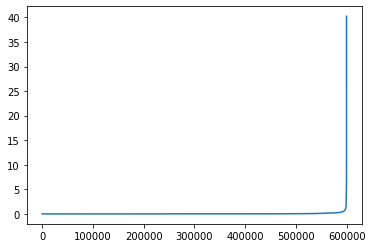

In [11]:
lgs_log = lgs.coef_[0]
lgs_log = np.abs(lgs_log)
plt.plot(np.sort(lgs_log))
plt.xlim()
plt.ylim()

In [12]:
#reduce X
#we take into consideration an ulr only if it's coef is > 0.41 
X_Reduced_train = X_train[:, lgs_log > 0.41]
X_Reduced_test = X_test[:, lgs_log > 0.41]

lgs_reduced = lgs_log[ lgs_log > 0.41]

In [13]:
lgs_mod = LogisticRegression()
lgs_mod.fit(X_Reduced_train, y_train)
print(lgs_mod.score(X_Reduced_test,y_test))

0.9933506860464223


c:\users\yinnan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
y_pred = lgs.predict(X)

In [15]:
y_int = []
y_pred_int = []
for i in y:
    if(i == "bad"):
        y_int.append(0)
    else:
        y_int.append(1)
    
for i in y_pred:
    if(i == "bad"):
        y_pred_int.append(0)
    else:
        y_pred_int.append(1)

In [16]:
np.unique(y)

array(['bad', 'benign'], dtype='<U6')

In [17]:
#recall_score, average precision, f1 score
print(recall_score(y, y_pred, pos_label = 'benign'))
print(average_precision_score(y_int, y_pred_int))
print(f1_score(y, y_pred, pos_label = 'benign'))

0.9986457072735481
0.9943145251237935
0.9966590767037492
